# Prithvi tutorial

This tutorial demonstrates how to work with the [Prithvi](https://github.com/NASA-IMPACT/hls-foundation-os/tree/main) model.

Prithvi is a first-of-its-kind temporal Vision transformer pre-trained by the IBM and NASA team on contiguous US Harmonised Landsat Sentinel 2 (HLS) data. The model adopts a self-supervised encoder developed with a ViT architecture and Masked AutoEncoder (MAE) learning strategy, with an MSE loss function. The model includes spatial attention across multiple patches and also temporal attention for each patch.

## Methodology

This tutorial will demonstrate how to utilize the fine-tuned version of the Prithvi model to [detect burn scars](https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-Burn-scars-demo) on new data in `numpy` array and  `GeoTIFF` format. As an example, we will detect burn scars using the [NASA HLS fire scars dataset](https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars).

## Setup

### Library import

In [2]:
import os
import glob

import numpy as np
import torch
from mmcv import Config
from mmcv.parallel import collate, scatter
from mmseg.apis import init_segmentor
from mmseg.datasets.pipelines import Compose, LoadImageFromFile
from mmseg.models import build_segmentor
from tifffile import imread
import matplotlib.pyplot as plt

/home/iker/mambaforge/envs/hls_data_project/lib/python3.11/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


### Utils

In [3]:
def process_test_pipeline(custom_test_pipeline, bands=None):
    # change extracted bands if necessary
    if bands is not None:
        extract_index = [
            i for i, x in enumerate(custom_test_pipeline) if x["type"] == "BandsExtract"
        ]

        if len(extract_index) > 0:
            custom_test_pipeline[extract_index[0]]["bands"] = eval(bands)

    collect_index = [
        i for i, x in enumerate(custom_test_pipeline) if x["type"].find("Collect") > -1
    ]

    # adapt collected keys if necessary
    if len(collect_index) > 0:
        keys = [
            "img_info",
            "filename",
            "ori_filename",
            "img",
            "img_shape",
            "ori_shape",
            "pad_shape",
            "scale_factor",
            "img_norm_cfg",
        ]
        custom_test_pipeline[collect_index[0]]["meta_keys"] = keys

    return custom_test_pipeline

In [4]:
def process_test_pipeline_array(custom_test_pipeline, bands=None):
    # change extracted bands if necessary
    if bands is not None:
        extract_index = [
            i for i, x in enumerate(custom_test_pipeline) if x["type"] == "BandsExtract"
        ]

        if len(extract_index) > 0:
            custom_test_pipeline[extract_index[0]]["bands"] = eval(bands)

    collect_index = [
        i for i, x in enumerate(custom_test_pipeline) if x["type"].find("Collect") > -1
    ]

    # adapt collected keys if necessary
    if len(collect_index) > 0:
        keys = [
            "img_info",
            "img",
            "img_shape",
            "ori_shape",
            "pad_shape",
            "scale_factor",
            "img_norm_cfg",
        ]
        custom_test_pipeline[collect_index[0]]["meta_keys"] = keys

    return custom_test_pipeline

In [5]:
def open_tiff(fname):
    data = imread(fname)
    return data

## Inference

### Input image from `GeoTIFF` file

**Variables**

In [5]:
config_path = "../Prithvi/configs/burn_scars_Prithvi_100M.py"
ckpt = "../Prithvi/checkpoints/burn_scars_Prithvi_100M.pth"
input_type = "tif"
input_path = "../data/raw/burn_scars/"
output_path = "../data/processed/burn_scars/"
bands = "[0,1,2,3,4,5]"

**Load model and images**

In [6]:
# load model
config = Config.fromfile(config_path)
config.model.backbone.pretrained = None
model = init_segmentor(config, ckpt)

# identify images to predict on
target_images = glob.glob(input_path + "*." + input_type)

print("Identified images to predict on: " + str(len(target_images)))

# check if output folder available
if not os.path.isdir(output_path):
    os.mkdir(output_path)

# modify test pipeline if necessary
custom_test_pipeline = process_test_pipeline(model.cfg.data.test.pipeline, bands)

# for each image predict and save to disk
for i, target_image in enumerate(target_images):
    print(f"Working on Image {i}")
    output_image = output_path + target_image.split("/")[-1].replace(
        "." + input_type, "_pred." + input_type
    )

/home/iker/mambaforge/envs/hls_data_project/lib/python3.11/site-packages/mmseg/models/decode_heads/decode_head.py:104: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert seg_logist into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'


load checkpoint from local path: ../Prithvi/checkpoints/burn_scars_Prithvi_100M.pth
Identified images to predict on: 3
Working on Image 0
Working on Image 1
Working on Image 2


**Predict**

In [7]:
model = model
imgs = target_image
custom_test_pipeline = custom_test_pipeline

In [8]:
cfg = model.cfg
device = next(model.parameters()).device  # model device
# build the data pipeline
test_pipeline = (
    [LoadImageFromFile()] + cfg.data.test.pipeline[1:]
    if custom_test_pipeline == None
    else custom_test_pipeline
)
test_pipeline = Compose(test_pipeline)
# prepare data
data = []
imgs = imgs if isinstance(imgs, list) else [imgs]
for img in imgs:
    img_data = {"img_info": {"filename": img}}
    img_data = test_pipeline(img_data)
    data.append(img_data)

data = collate(data, samples_per_gpu=len(imgs))
if next(model.parameters()).is_cuda:
    # data = collate(data, samples_per_gpu=len(imgs))
    # scatter to specified GPU
    data = scatter(data, [device])[0]
else:
    # img_metas = scatter(data['img_metas'],'cpu')
    # data['img_metas'] = [i.data[0] for i in data['img_metas']]
    img_metas = data["img_metas"].data[0]
    img = data["img"]
    data = {"img": img, "img_metas": img_metas}

# predict 
with torch.no_grad():
    result = model(return_loss=False, rescale=True, **data)

### Input image from numpy array

**Variables**

In [6]:
config_path = "../Prithvi/configs/burn_scars_Prithvi_100M_array.py"
ckpt = "../Prithvi/checkpoints/burn_scars_Prithvi_100M.pth"
input_type = "tif"
input_path = "../data/raw/burn_scars/"
output_path = "../data/processed/burn_scars/"
bands = "[0,1,2,3,4,5]"

**Load model and images**

In [7]:
# load model
config = Config.fromfile(config_path)
config.model.backbone.pretrained = None
model = init_segmentor(config, ckpt)

# identify images to predict on
target_images = glob.glob(input_path + "*." + input_type)

print("Identified images to predict on: " + str(len(target_images)))

# check if output folder available
if not os.path.isdir(output_path):
    os.mkdir(output_path)

# modify test pipeline if necessary
custom_test_pipeline = process_test_pipeline_array(model.cfg.data.test.pipeline, bands)

# read image
img = target_images[0]
array = open_tiff(img)

/home/iker/mambaforge/envs/hls_data_project/lib/python3.11/site-packages/mmseg/models/decode_heads/decode_head.py:104: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert seg_logist into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'


load checkpoint from local path: ../Prithvi/checkpoints/burn_scars_Prithvi_100M.pth
Identified images to predict on: 3


**Predict**

In [8]:
cfg = model.cfg
device = next(model.parameters()).device  # model device
# build the data pipeline
test_pipeline = (
    [LoadImageFromFile()] + cfg.data.test.pipeline[1:]
    if custom_test_pipeline == None
    else custom_test_pipeline
)
test_pipeline = Compose(test_pipeline)
# prepare data
data = []
img_data = {"img_info": {"array": array}}
img_data = test_pipeline(img_data)
data.append(img_data)

data = collate(data, samples_per_gpu=1)
if next(model.parameters()).is_cuda:
    # data = collate(data, samples_per_gpu=len(imgs))
    # scatter to specified GPU
    data = scatter(data, [device])[0]
else:
    # img_metas = scatter(data['img_metas'],'cpu')
    # data['img_metas'] = [i.data[0] for i in data['img_metas']]
    img_metas = data["img_metas"].data[0]
    img = data["img"]
    data = {"img": img, "img_metas": img_metas}

# predict 
with torch.no_grad():
    result = model(return_loss=False, rescale=True, **data)

**Display input/output**

In [38]:
# Input
blue_data = array[:,:,0]
green_data = array[:,:,1]
red_data = array[:,:,2]
nir_data = array[:,:,3]
swir_data = array[:,:,5]
# Output
mask = result[0]

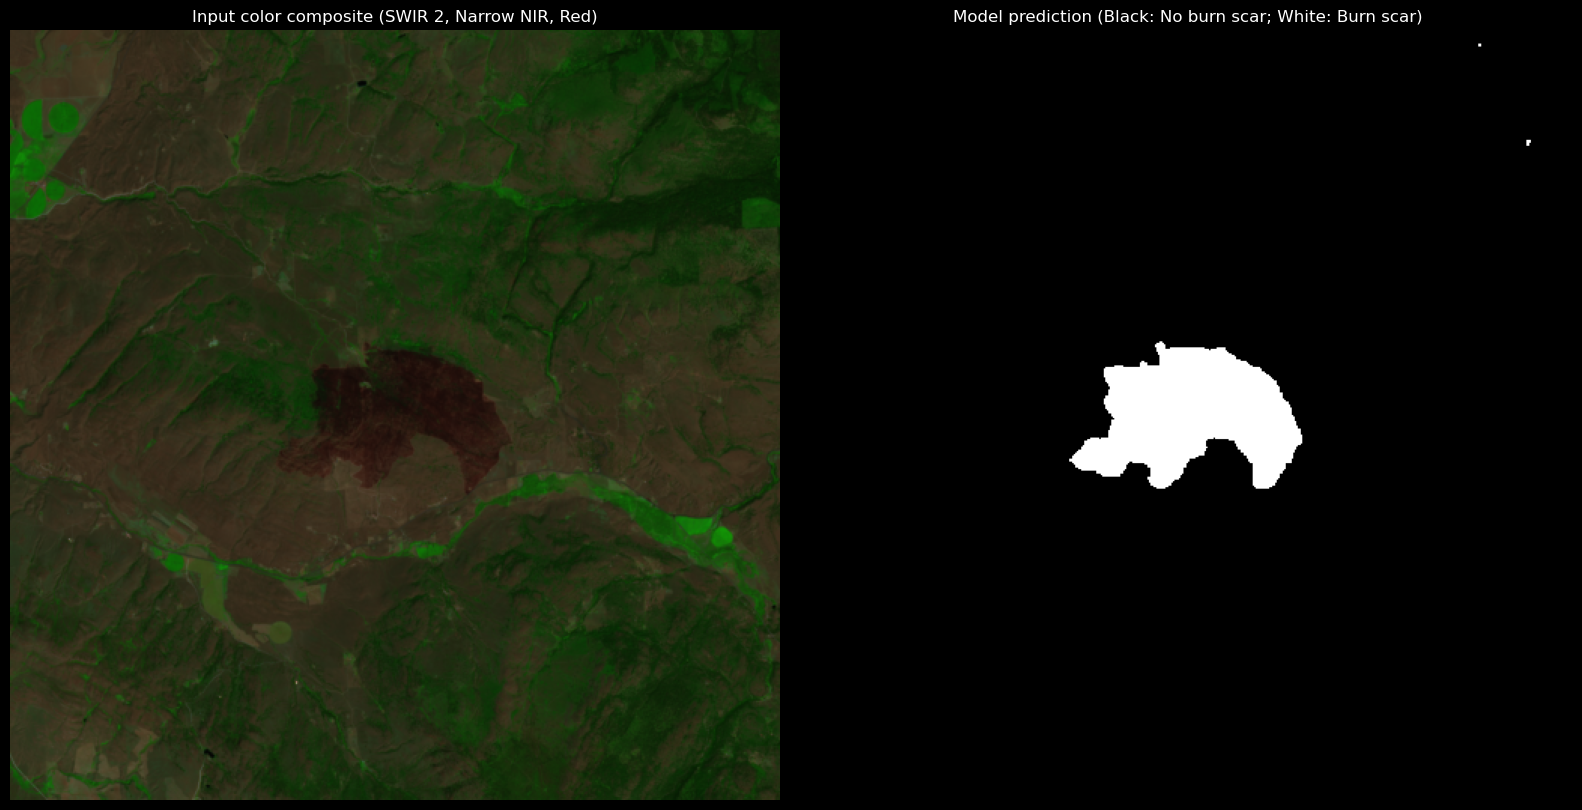

In [37]:

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Display the RGB image using the first axes
rgb_image = np.stack((swir_data, nir_data, red_data), axis=-1)

ax[0].imshow(rgb_image)
ax[0].set_title("Input color composite (SWIR 2, Narrow NIR, Red)")
ax[0].axis('off')

# Display another image using the second axes
ax[1].imshow(result[0], cmap='gray')
ax[1].set_title("Model prediction (Black: No burn scar; White: Burn scar)")
ax[1].axis('off')

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()